# Table of Contents

[Libraries](#Libraries) <br>
[Variables](#Variables)
1. [Data Import & Manipulation](#1.-Data-Import-&-Manipulation) 
    1. [Fuel Output & Demand Data](#A.-Fuel-Output-&-Demand-Data)
    2. [HOEP Data](#B.-HOEP-Data)
    3. [NG Production & Demand Data](#C.-NG-Production-&-Demand-Data)
    4. [Transportation Demand Data](#D.-Transportation-Demand-Data)
    5. [Industry Demand Data](#E.-Industry-Demand-Data)
    6. [Emission Factor Calculation](#F.-Emission-Factor-Calculation)
    7. [Input Data to MILP](#G.-Input-Data-to-MILP)
2. [Mixed Integer Linear Programming](#2.-Mixed-Integer-Linear-Programming)
    1. [RNG MILP](#A.-RNG-MILP)
    2. [HENG MILP](#B.-HENG-MILP)
    3. [Transportation MILP](#C.-Transportation-MILP)
    4. [Industry MILP](#D.-Industry-MILP)
    5. [Combined MILP](#E.-Combined-MILP)
3. [Results](#3.-Results)
    1. [Individual Result](#A.-Individual-Result)
    2. [Combined Result](#B.-Combined-Result)


# Libraries

In [1]:
import pandas as pd

# Variables 

Import the csv file with variables 

In [2]:
raw=pd.read_csv('Variables.csv')
raw2=raw.dropna(axis='columns',how='all')
var=raw2.dropna(axis='rows',how='all')
var.set_index("variable_name",inplace=True)

In [3]:
var

,value,unit,source,comment
variable_name,,,,
MW_H2,1.008000e+00,kg/kmol,internet,NaN
density_H2,8.990000e-02,kg/m^3,ushnik,NaN
electrolyzer_eff,7.667000e-01,dimensionless,eqtn 3.1,NaN
E_hhv_h2,3.550000e+00,kWh/m^3 H2,eqtn 3.1,NaN
E_rated_h2,4.630000e+00,kWh/m^3 H2,eqtn 3.1,NaN
min_E_cap,0.000000e+00,kWh,eqtn 3.3,NaN
max_E_cap,1.000000e+03,kWh,eqtn 3.3,NaN
water_cons_rate,4.000000e-01,L H2O/m^3 H2,eqtn 3.4,NaN
meth_reactor_eff,7.700000e-01,dimensionless,eqtn 3.13,NaN


# 1. Data Import & Manipuation

## A. Fuel Output & Demand Data

Import the fuel output data by sources (i.e. nuclear, gas, hydro)

In [4]:
fuel_output = pd.read_csv('on_fuel_source_output_2017.csv', keep_default_na=False, na_values=[""])

Impor the fuel demand in Onatrio data 

In [5]:
fuel_demand = pd.read_csv('on_demand_2017.csv', keep_default_na=False, na_values=[""])

Subtract 1 hour from the hour because we want 0 to 23 hr 

In [6]:
fuel_output['Hour'] = fuel_output['Hour'] - 1

In [7]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,0,NUCLEAR,11592
1,2017-01-01,0,GAS,234
2,2017-01-01,0,HYDRO,2455
3,2017-01-01,0,WIND,2433
4,2017-01-01,0,SOLAR,0


In [8]:
fuel_demand['Hour'] = fuel_demand['Hour'] -1

In [9]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create Datetime columns in both dataframes

In [10]:
fuel_output['Datetime'] = pd.to_datetime(fuel_output['Date']) + pd.to_timedelta(fuel_output['Hour'], unit='h')

In [11]:
fuel_output.head()

,Date,Hour,Fuel,Output,Datetime
0,2017-01-01,0,NUCLEAR,11592,2017-01-01
1,2017-01-01,0,GAS,234,2017-01-01
2,2017-01-01,0,HYDRO,2455,2017-01-01
3,2017-01-01,0,WIND,2433,2017-01-01
4,2017-01-01,0,SOLAR,0,2017-01-01


In [12]:
fuel_demand['Datetime'] = pd.to_datetime(fuel_demand['Date']) + pd.to_timedelta(fuel_demand['Hour'], unit='h')

In [13]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Datetime
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268",2017-01-01 00:00:00
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673",2017-01-01 01:00:00
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974",2017-01-01 02:00:00
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186",2017-01-01 03:00:00
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227",2017-01-01 04:00:00


Groupby the fuel data dataframe by Datetime

In [14]:
fuel_output_total = pd.DataFrame(fuel_output.groupby('Datetime')['Output'].sum())
fuel_output_total.columns = ['fuel_total']

In [15]:
fuel_output_total.head()

,fuel_total
Datetime,
2017-01-01 00:00:00,16715
2017-01-01 01:00:00,16344
2017-01-01 02:00:00,15942
2017-01-01 03:00:00,15727
2017-01-01 04:00:00,15653


Set index of the demand dataframe using Datetime

In [16]:
fuel_demand.set_index('Datetime',inplace=True)

In [17]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
2017-01-01 01:00:00,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2017-01-01 02:00:00,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
2017-01-01 03:00:00,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
2017-01-01 04:00:00,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create SBG data by joining the two data demand and output data and taking the difference between the two 

In [18]:
SBG = pd.merge(fuel_output_total[['fuel_total']],fuel_demand[['Ontario Demand']], how='inner',left_index=True, right_index=True)

In [19]:
SBG.head()

,fuel_total,Ontario Demand
Datetime,,
2017-01-01 00:00:00,16715,13522
2017-01-01 01:00:00,16344,13117
2017-01-01 02:00:00,15942,12816
2017-01-01 03:00:00,15727,12605
2017-01-01 04:00:00,15653,12563


In [20]:
SBG['Difference'] = SBG['fuel_total'] - SBG['Ontario Demand']

In [21]:
SBG.head()

,fuel_total,Ontario Demand,Difference
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193
2017-01-01 01:00:00,16344,13117,3227
2017-01-01 02:00:00,15942,12816,3126
2017-01-01 03:00:00,15727,12605,3122
2017-01-01 04:00:00,15653,12563,3090


Check if there's any cell with difference less than 0

In [22]:
SBG[SBG['Difference']<0].count()

fuel_total        697
Ontario Demand    697
Difference        697
dtype: int64

Assign negative numbers with 0's 

In [23]:
SBG.loc[SBG['Difference']<=0,'Difference'] = 0

In [24]:
SBG[SBG['Difference']<0].count()

fuel_total        0
Ontario Demand    0
Difference        0
dtype: int64

Convert SBG from MWh to kWh

In [25]:
SBG['Difference'] = SBG['Difference']*1000

Change the column names of the SBG dataframe 

In [26]:
SBG.columns = ['fuel_output','fuel_demand','SBG(kWh)']

In [27]:
SBG.head()

,fuel_output,fuel_demand,SBG(kWh)
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193000
2017-01-01 01:00:00,16344,13117,3227000
2017-01-01 02:00:00,15942,12816,3126000
2017-01-01 03:00:00,15727,12605,3122000
2017-01-01 04:00:00,15653,12563,3090000


## B. HOEP Data

Import the HOEP data <br>
Note: HOEP values are reported as $/MWh

In [28]:
hoep_data = pd.read_csv('HOEP_2017.csv', keep_default_na=False, na_values=[""])

In [29]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
0,2017-01-01,1,0.0,5.94,0.0,0.0,NaN,NaN,NaN
1,2017-01-01,2,0.0,0.00,2.2,0.0,NaN,NaN,NaN
2,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN
3,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN
4,2017-01-01,5,0.0,0.00,0.0,0.0,NaN,NaN,NaN


Change the hour to hour-1

In [30]:
hoep_data['Hour'] = hoep_data['Hour'] -1

Create datetime column

In [31]:
hoep_data['Datetime'] = pd.to_datetime(hoep_data['Date']) + pd.to_timedelta(hoep_data['Hour'], unit='h')

In [32]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,Datetime
0,2017-01-01,0,0.0,5.94,0.0,0.0,NaN,NaN,NaN,2017-01-01 00:00:00
1,2017-01-01,1,0.0,0.00,2.2,0.0,NaN,NaN,NaN,2017-01-01 01:00:00
2,2017-01-01,2,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 02:00:00
3,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 03:00:00
4,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 04:00:00


Set the index of the hoep data using the datetime

In [33]:
hoep_data.set_index('Datetime',inplace=True)

In [34]:
hoep_data.head(10)

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
Datetime,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,0.00,5.94,0.00,0.00,NaN,NaN,NaN
2017-01-01 01:00:00,2017-01-01,1,0.00,0.00,2.20,0.00,NaN,NaN,NaN
2017-01-01 02:00:00,2017-01-01,2,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 03:00:00,2017-01-01,3,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 04:00:00,2017-01-01,4,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 05:00:00,2017-01-01,5,0.00,0.01,0.00,1.99,NaN,NaN,NaN
2017-01-01 06:00:00,2017-01-01,6,0.00,5.94,6.04,6.02,NaN,NaN,NaN
2017-01-01 07:00:00,2017-01-01,7,1.71,6.74,8.42,6.74,NaN,NaN,NaN
2017-01-01 08:00:00,2017-01-01,8,0.00,5.74,5.70,5.84,NaN,NaN,NaN


HOEP data is dollar/Mwh so need to convert to dollar/kWh

In [35]:
hoep_data['HOEP']= hoep_data['HOEP']/1000

Merge the SBG data and HOEP data

In [36]:
input_df = pd.merge(SBG[['SBG(kWh)']],hoep_data[['HOEP']], how='inner',left_index=True, right_index=True)

In [37]:
input_df.head(10)

,SBG(kWh),HOEP
Datetime,,
2017-01-01 00:00:00,3193000,0.00000
2017-01-01 01:00:00,3227000,0.00000
2017-01-01 02:00:00,3126000,0.00000
2017-01-01 03:00:00,3122000,0.00000
2017-01-01 04:00:00,3090000,0.00000
2017-01-01 05:00:00,2898000,0.00000
2017-01-01 06:00:00,2739000,0.00000
2017-01-01 07:00:00,2726000,0.00171
2017-01-01 08:00:00,2267000,0.00000


## C. NG Production & Demand Data

Import the NG hourly distribution data

In [38]:
NG_hourly_distribution = pd.read_csv('NG_hourly_distribution.csv')

In [39]:
NG_hourly_distribution.head(24)

,hour,hourly_distribution
0,1,105
1,2,100
2,3,95
3,4,95
4,5,100
5,6,110
6,7,140
7,8,145
8,9,125
9,10,120


Calculate the ratio of the distribution each hour using hourly distribution divided by the sum of the hourly distribution 

In [40]:
NG_hourly_distribution['ratio'] = NG_hourly_distribution['hourly_distribution']/sum(NG_hourly_distribution['hourly_distribution'])

Substract 1 from the hour

In [41]:
NG_hourly_distribution['hour'] = NG_hourly_distribution['hour']-1

In [42]:
NG_hourly_distribution.head()

,hour,hourly_distribution,ratio
0,0,105,0.033113
1,1,100,0.031536
2,2,95,0.029959
3,3,95,0.029959
4,4,100,0.031536


Import the NG monthly production data

In [43]:
NG_monthly_production = pd.read_csv('NG_monthly_production.csv')

In [44]:
NG_monthly_production.head()

,month,NG_production(e3m3/d)
0,1,6184
1,2,6165
2,3,6168
3,4,5978
4,5,6170


Create NG demand column in the input_df

In [45]:
input_df['NG_demand(m^3)'] = 0
input_df['NG_demand(m^3)'] = input_df['NG_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,0.0
2017-01-01 01:00:00,3227000,0.0,0.0
2017-01-01 02:00:00,3126000,0.0,0.0
2017-01-01 03:00:00,3122000,0.0,0.0
2017-01-01 04:00:00,3090000,0.0,0.0


NG demand calculation: hourly NG demand = ratio at that hour * production in that month

In [46]:
for index, row in input_df.iterrows():
   
    curr_hour = index.hour
    curr_month = index.month 
    ratio = NG_hourly_distribution[NG_hourly_distribution['hour']==curr_hour]['ratio'].iloc[0]
    NG_prod = NG_monthly_production[NG_monthly_production['month']==curr_month]['NG_production(e3m3/d)'].iloc[0]
  
    input_df.loc[index,'NG_demand(m^3)'] = (ratio * NG_prod).round(3)*1000
    

In [47]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,204768.0
2017-01-01 01:00:00,3227000,0.0,195017.0
2017-01-01 02:00:00,3126000,0.0,185266.0
2017-01-01 03:00:00,3122000,0.0,185266.0
2017-01-01 04:00:00,3090000,0.0,195017.0


## D. Transportation Demand Data

Import the mobility demand data 

In [48]:
mobility_hourly_distribution = pd.read_csv('mobility_hourly_distribution.csv')

In [49]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,1,1.05
1,2,0.80
2,3,0.70
3,4,0.40
4,5,0.90


Change the hour to hour-1

In [50]:
mobility_hourly_distribution['hour'] = mobility_hourly_distribution['hour'] -1

In [51]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,0,1.05
1,1,0.80
2,2,0.70
3,3,0.40
4,4,0.90


In [52]:
mobility_hourly_distribution

,hour,% of daily demand
0,0,1.05
1,1,0.80
2,2,0.70
3,3,0.40
4,4,0.90
5,5,1.10
6,6,2.05
7,7,3.05
8,8,4.05
9,9,5.60


mobility monthly hour distribution = mobility hourly distribution * 264000 kg demand * 1m^3/0.0899kg H2 

In [53]:
mobility_hourly_distribution['demand(m^3)'] = mobility_hourly_distribution['% of daily demand'] / 100 * 264000 /0.0899

In [54]:
mobility_hourly_distribution.head()

,hour,% of daily demand,demand(m^3)
0,0,1.05,30834.260289
1,1,0.80,23492.769744
2,2,0.70,20556.173526
3,3,0.40,11746.384872
4,4,0.90,26429.365962


Weekly profile according to the mobility Excel workbook

In [55]:
# weekday number 6= Sunday, 0 = Monday,... 5 = Saturday 
week_profile_dict = {'weekday': [6,0,1,2,3,4,5],
         'factor': [101,94,96,100,105,108,96]}

week_profile_df = pd.DataFrame.from_dict(week_profile_dict)

week_profile_df['factor_fraction'] = week_profile_df['factor']/100
week_profile_df

,factor,weekday,factor_fraction
0,101,6,1.01
1,94,0,0.94
2,96,1,0.96
3,100,2,1.00
4,105,3,1.05
5,108,4,1.08
6,96,5,0.96


Create mobility demand column in the input data

In [56]:
input_df['mobility_demand(m^3)'] = 0
input_df['mobility_demand(m^3)'] = input_df['mobility_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,0.0


Calculate mobility demand hourly profile = weekday factor * hourly mobility demand

In [57]:
for index, row in input_df.iterrows():
    curr_weekday = index.weekday()
    curr_hour = index.hour 
    week_factor = week_profile_df[week_profile_df['weekday']==curr_weekday]['factor_fraction'].iloc[0]
    mob_demand = mobility_hourly_distribution[mobility_hourly_distribution['hour']==curr_hour]['demand(m^3)'].iloc[0]
    input_df.loc[index,'mobility_demand(m^3)'] = mob_demand * week_factor 

In [58]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622


## E. Industry Demand Data

Total industry production capacity (MSm^3/day)

In [59]:
total_daily_production = 6.3 #MSm^3/day

Total yearly production

In [60]:
total_yearly_production = total_daily_production * 365

print(total_yearly_production)

2299.5


Industry monthly demand according to the paper = monthly demand hydrogen percetnage * total yearly production 

In [61]:
ind_demand_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'monthly_demand_hydrogen[kg]': [3.2,2.7,2.4,2.1,2,1.8,1.7,2,2.1,2.7,3,3.3]
         }
monthly_hydrogen_demand = pd.DataFrame.from_dict(ind_demand_dic)
total_hydrogen_demand = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]'].sum()
monthly_hydrogen_demand['percentage'] = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]']/total_hydrogen_demand
monthly_hydrogen_demand['production_capacity[m^3/day]'] = total_yearly_production * monthly_hydrogen_demand['percentage'] * (10**6)
monthly_hydrogen_demand

,month,monthly_demand_hydrogen[kg],percentage,production_capacity[m^3/day]
0,1,3.2,0.110345,2.537379e+08
1,2,2.7,0.093103,2.140914e+08
2,3,2.4,0.082759,1.903034e+08
3,4,2.1,0.072414,1.665155e+08
4,5,2.0,0.068966,1.585862e+08
5,6,1.8,0.062069,1.427276e+08
6,7,1.7,0.058621,1.347983e+08
7,8,2.0,0.068966,1.585862e+08
8,9,2.1,0.072414,1.665155e+08
9,10,2.7,0.093103,2.140914e+08


Creating empty column in the input df for industry demand

In [62]:
input_df['industry_demand(m^3)'] = 0
input_df['industry_demand(m^3)'] = input_df['industry_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,0.0


number of days in each month

In [63]:
num_days_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'number_of_days': [31,28,31,30,31,30,31,31,30,31,30,31]}
num_days_df = pd.DataFrame.from_dict(num_days_dic)
num_days_df

,month,number_of_days
0,1,31
1,2,28
2,3,31
3,4,30
4,5,31
5,6,30
6,7,31
7,8,31
8,9,30
9,10,31


Create hourly profile for industry demand = monthly production capacity / number of days in the month * 24 hours in month * 0.05 (5% demand supply criteria)

In [64]:
for index, row in input_df.iterrows():
    curr_month = index.month 
    num_days = num_days_df[num_days_df['month']==curr_month]['number_of_days'].iloc[0]
    ind_prod = monthly_hydrogen_demand[monthly_hydrogen_demand['month']==curr_month]['production_capacity[m^3/day]'].iloc[0]
    input_df.loc[index,'industry_demand(m^3)'] = ind_prod / (num_days * 24) * 0.05

In [65]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311


## F. Emission Factor Calculation

Hourly average emission factor calculated using the fuel output 

In [66]:
#EMF(tonne/kWh)

emission_factor = fuel_output.copy()
emission_factor['Emission'] = 0
emission_factor['Emission'] = emission_factor['Emission'].astype(float)
emission_factor.head()


#all in kgCO2/MWh 
EMF_nuclear = 17 
EMF_gas = 622
EMF_hydro = 18
EMF_wind = 14
EMF_solar = 39
EMF_biofuel = 177


for index, row in emission_factor.iterrows():
    fuel_type = row['Fuel']
    
    if fuel_type == 'NUCLEAR':
        EMF = EMF_nuclear
    elif fuel_type == 'GAS':
        EMF = EMF_gas
    elif fuel_type == 'HYDRO':
        EMF = EMF_hydro
    elif fuel_type == 'BIOFUEL':
        EMF = EMF_biofuel
    elif fuel_type == 'SOLAR':
        EMF = EMF_solar
    else:
        EMF = EMF_wind
        
    emission_factor.loc[index,'Emission'] = EMF * emission_factor.loc[index,'Output']

emission_factor.head()

emission_factor_agg = pd.DataFrame(emission_factor.groupby('Datetime').agg({'Emission':'sum','Output':'sum'}))

emission_factor_agg['EMF(kgCO2/MWh)'] = emission_factor_agg['Emission'] / emission_factor_agg['Output'] 
emission_factor_agg['EMF(tonne/kWh)'] = emission_factor_agg['EMF(kgCO2/MWh)'] / 1000 / 1000 #unit conversion 1tonne/1000kg, 1MW/1000kW
emission_factor_agg.head()

,Emission,Output,EMF(kgCO2/MWh),EMF(tonne/kWh)
Datetime,,,,
2017-01-01 00:00:00,421041.0,16715,25.189411,0.000025
2017-01-01 01:00:00,416724.0,16344,25.497063,0.000025
2017-01-01 02:00:00,410267.0,15942,25.734977,0.000026
2017-01-01 03:00:00,408635.0,15727,25.983023,0.000026
2017-01-01 04:00:00,406922.0,15653,25.996422,0.000026


In [67]:
input_df = pd.merge(input_df,emission_factor_agg[['EMF(tonne/kWh)']], how='inner',left_index=True, right_index=True)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
Datetime,,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311,0.000025
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311,0.000025
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311,0.000026
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311,0.000026
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311,0.000026


## G. Input Data to MILP

In [68]:
input_df.head(10)

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
Datetime,,,,,,
2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026


In [69]:
input_df.reset_index(inplace=True)
input_df.head(10)

,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
0,2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
1,2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2,2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
3,2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
4,2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
5,2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
6,2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
7,2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
8,2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026
9,2017-01-01 09:00:00,2324000,0.00000,234021.0,166093.882091,17052.280311,0.000026


# 2. Mixed Integer Linear Programming

Numbering variables 
<br>
1. RNG <br>
2. HENG <br>
3. Transportation <br>
4. Industry

## A. RNG MILP

## B. HENG MILP

## C. Transportation MILP

## D. Industry MILP

## E. Combined MILP

# 3. Results

## A. Individual Result 

Functions for creating variable df using the result df (from the exported result csv) 

In [70]:
import numpy as np

In [71]:
def create_var_df_from_result(df,col_string,exc_string=None,hour_str=None):
    '''
    df = the result df 
    col_string = the variable name of interest including _ at the end before the hour number (i.e. 'CO2_2_')
    exc_string = the variable you do not want to include (just in case of RNG and RNG_max, this case exc_string="RNG_max")
    hour_str = if the variable is an hourly variable, hour_str='Y'
    '''
   
    if exc_string is not None: #if you include the string to exclude
        variable_df = df[(df['variable'].str.startswith(col_string)) & (~df['variable'].str.contains(exc_string))].copy()
    else:
        variable_df = df[df['variable'].str.startswith(col_string)].copy()

#     print('The length of variable df: ',len(variable_df))

    if (hour_str is not None) & (hour_str == 'Y'): #if you include anything here
        #split the name and create an hour 
        variable_df['hour'] = variable_df['variable'].apply(lambda x: x.split(col_string)[1])
        #convert the data type to integer 
        variable_df['hour'] = variable_df['hour'].astype(int)
        #sort the df by hour 
        variable_df.sort_values(by=['hour'],inplace=True)
#         print("The first 5 hours of the data:")
    else:
        pass
    
#     display(variable_df.head())
    
    return variable_df 

Functions for creating plots 

In [72]:
#function for creating plot from df 
def create_plot_df(df,x_axis_label,y_axis_label):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(df['hour'],df['value'])
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
 
    
#function for creating plot from list
def create_plot_list(x_list,y_list,x_axis_label,y_axis_label):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(x_list,y_list,linestyle='--', marker='o')
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

## NOTE: The OPEX results saved in csv files are NOT multiplied to TVM

In [73]:
RNG_result_df = pd.read_csv('RNG_result.csv')
RNG_result_df.tail()

,Unnamed: 0,variable,value
73598,73598,em_rng,5.831785e+06
73599,73599,LP_cost_status,1.000000e+00
73600,73600,LP_cost_time,2.771084e+03
73601,73601,offset_max,1.161300e+04
73602,73602,phi,5.000000e-01


In [74]:
HENG_result_df = pd.read_csv('HENG_result.csv')
HENG_result_df.tail()

,Unnamed: 0,variable,value
56077,56077,em_offset_2,138798.150000
56078,56078,LP_cost_status,1.000000
56079,56079,LP_cost_time,458.091843
56080,56080,offset_max,277596.300000
56081,56081,phi,0.500000


In [75]:
transportation_result_df = pd.read_csv('transportation_result.csv')
transportation_result_df.tail()

,Unnamed: 0,variable,value
56079,56079,em_sbg_3,151059.280000
56080,56080,LP_cost_status,1.000000
56081,56081,LP_cost_time,896.547864
56082,56082,offset_max,304413.060900
56083,56083,phi,0.500000


In [76]:
industry_result_df = pd.read_csv('industry_result.csv')
industry_result_df.tail()

,Unnamed: 0,variable,value
56079,56079,em_sbg_4,18512.448000
56080,56080,LP_cost_status,1.000000
56081,56081,LP_cost_time,852.628049
56082,56082,offset_max,170954.014540
56083,56083,phi,0.500000


In [77]:
TVM = var['value']['TVM'] #time money value
SBG = list(input_df['SBG(kWh)']) # SBG list
NG_demand = list(input_df['NG_demand(m^3)'])
mobility_demand = list(input_df['mobility_demand(m^3)'])
industry_demand = list(input_df['industry_demand(m^3)']) 

i = 0
index_label = ['RNG','HENG','Transportation','Industry']

for col_name in ['N_electrolyzer','N_booster','N_prestorage','N_tank','em_offset','offset_max','CAPEX','OPEX']:
    i += 1
    var_list = []
    if col_name == 'N_booster':
        df = transportation_result_df
        var_list = [0,0,0,0]
        col_name_2 = df[df['variable'].str.contains(col_name)]['variable'].tolist()[0]
        var_value = df.loc[df['variable']==col_name_2,'value'].tolist()[0]
        var_list[2] = var_value
    else:
        for df in [RNG_result_df, HENG_result_df, transportation_result_df, industry_result_df]:
            col_name_2 = df[df['variable'].str.contains(col_name)]['variable'].tolist()[0]
            var_value = df.loc[df['variable']==col_name_2,'value'].tolist()[0]
            var_list.append(var_value)
    
    temp_df = pd.DataFrame({col_name : var_list})
    if i == 1:   
        final_df = temp_df.copy()
    else:
        final_df = pd.concat([final_df,temp_df],axis=1)#,ignore_index=True)

#calculate the total cost 
final_df['total_cost($)'] = final_df['CAPEX'] + final_df['OPEX'] * TVM

#add SBG count zero column 
SBG_count_zero_list = [len(SBG) - np.count_nonzero(SBG)] * 4
SBG_sum_list = [sum(SBG) * (10**-8)] * 4
final_df = pd.concat([final_df,pd.DataFrame(SBG_count_zero_list,columns=['SBG_count_zero'])],axis=1)
final_df = pd.concat([final_df,pd.DataFrame(SBG_sum_list,columns=['Total SBG Available (10^8 kWh)'])],axis=1)



#add Eh count zero column 
E_count_zero_list = []
E_sum_list = []
E_SBG_pct_list = []
E_mean_list = []

H2_gen_list = [] #total H2 generated using the total electricity consumed; H2 direct + H2 tank in
H2_sup_list = [] #total H2 supplied; H2 direct + H2 tank out 
H2_tank_inv_list = [] #last inventory in the tank
i = 0

for df in [RNG_result_df, HENG_result_df, transportation_result_df, industry_result_df]:
    i += 1
    if i == 1:
        col_index = '1'
        D = NG_demand.copy()
    elif i == 2:
        col_index = '2'
        D = NG_demand.copy()
    elif i == 3:
        col_index = '3'
        D = mobility_demand.copy()
    else:
        col_index = '4'
        D = industry_demand.copy()
    
    E_df = create_var_df_from_result(df,'E_'+ col_index + '_',hour_str='Y')
    
    E_list = list(E_df['value'])
    E_count_zero_list.append(len(E_list) - np.count_nonzero(E_list))
    
    E_sum = sum(E_list) * (10**-8)
    E_sum_list.append(E_sum)
    
    E_mean = np.mean(E_list)
    E_mean_list.append(E_mean)
    
    H2_df = create_var_df_from_result(df,'H2_'+ col_index + '_',hour_str='Y')
    H2_list = list(H2_df['value'])
    
    #Average SBG utilization 
    #The calculation ignores when SBG is 0 
    pct_list = []
    for x,y in zip(E_list,SBG):
        if y == 0:
            pct_list.append(np.NAN)
        else:
            pct_list.append(( x / y * 100 ))

    E_SBG_pct_list.append(np.nanmean(pct_list))
    
        
    if ((i == 1) or (i == 2)): #if RNG result or HENG result 
        H2_direct_df = create_var_df_from_result(df,'H2_direct_',hour_str='Y')
        H2_tank_in_df = create_var_df_from_result(df,'H2_tank_in_',hour_str='Y')
        H2_tank_out_df = create_var_df_from_result(df,'H2_tank_out_',hour_str='Y')
        I_H2_df = create_var_df_from_result(df,'I_H2_',hour_str='Y')
            

        H2_gen_list.append(H2_direct_df['value'].sum() + H2_tank_in_df['value'].sum())

        H2_sup_list.append(H2_direct_df['value'].sum() + H2_tank_out_df['value'].sum())
        
        H2_tank_inv_list.append(list(I_H2_df['value'])[-1])

    else:
        H2_gen_df = create_var_df_from_result(df,'H2_' + col_index + '_',hour_str='Y')
        H2_direct_df = create_var_df_from_result(df,'H2_direct_' + col_index + '_',hour_str='Y')
        H2_tank_out_df = create_var_df_from_result(df,'H2_tank_out_' + col_index + '_',hour_str='Y')
        I_H2_df = create_var_df_from_result(df,'I_H2_' + col_index + '_',hour_str='Y')

        H2_gen_list.append(H2_gen_df['value'].sum())
        H2_sup_list.append(H2_direct_df['value'].sum() + H2_tank_out_df['value'].sum())
        H2_tank_inv_list.append(list(I_H2_df['value'])[-1])



    
final_df['cost/offset'] = final_df['total_cost($)'] / final_df['em_offset']
final_df = pd.concat([final_df,pd.DataFrame(E_count_zero_list,columns=['E_count_zero'])],axis=1)
final_df = pd.concat([final_df,pd.DataFrame(E_sum_list,columns=['Total Electricity Used (10^8 kWh)'])],axis=1)
final_df = pd.concat([final_df,pd.DataFrame(E_mean_list,columns=['Average Electricity Used (kWh)'])],axis=1)
final_df = pd.concat([final_df,pd.DataFrame(E_SBG_pct_list,columns=['Average E/SBG %'])],axis=1)
final_df['Overall E/SBG %'] = final_df['Total Electricity Used (10^8 kWh)'] /  final_df['Total SBG Available (10^8 kWh)'] * 100
final_df['% emission offset'] = final_df['em_offset'] / final_df['offset_max'] *100
final_df = pd.concat([final_df,pd.DataFrame(H2_gen_list,columns=['H2_generated(m^3)'])],axis=1)
final_df = pd.concat([final_df,pd.DataFrame(H2_sup_list,columns=['H2_supplied(m^3)'])],axis=1)
final_df = pd.concat([final_df,pd.DataFrame(H2_tank_inv_list,columns=['last_inventory(m^3)'])],axis=1)


final_df = final_df.rename(columns = {'em_offset':'emission_offset(tonne CO2/year)'})



final_df.index = index_label
display(final_df)

,N_electrolyzer,N_booster,N_prestorage,N_tank,emission_offset(tonne CO2/year),offset_max,CAPEX,OPEX,total_cost($),SBG_count_zero,...,cost/offset,E_count_zero,Total Electricity Used (10^8 kWh),Average Electricity Used (kWh),Average E/SBG %,Overall E/SBG %,% emission offset,H2_generated(m^3),H2_supplied(m^3),last_inventory(m^3)
RNG,14.0,0.0,0.0,0.0,5806.50,11613.00000,4.248481e+06,1393999.5,1.793477e+07,698,...,3088.739911,3603,0.637846,7281.345051,0.611238,0.568994,50.000000,1.377567e+07,1.377567e+07,0.000
HENG,125.0,0.0,0.0,0.0,138798.15,277596.30000,5.430446e+04,2982132.5,2.933288e+07,698,...,211.334815,4043,2.838112,32398.538775,3.005437,2.531754,50.000000,6.129522e+07,6.129522e+07,0.000
Transportation,2609.0,514.0,1451.0,60467.0,282792.15,304413.06090,3.791289e+10,56373647.0,3.846636e+10,698,...,136023.452087,5339,49.630870,566562.442239,36.869681,44.273502,92.897509,1.071887e+09,1.071887e+09,5773739.100
Industry,275.0,0.0,177.0,504.0,165058.55,170954.01454,3.968083e+08,6246641.1,4.581379e+08,698,...,2775.608185,5639,5.323611,60771.813998,5.631569,4.748958,96.551433,1.149750e+08,1.149750e+08,48124.836


The last hour inventory is approximately equal to the number of tanks * I_min  for industry and transportation sectors

In [78]:
I_min = var['value']['Imin'] # kmol
MW_H2 = var['value']['MW_H2'] # kg/kmol H2
density_H2 = var['value']['density_H2'] # kg/m^3

I_min = I_min * MW_H2 / density_H2 # m^3
print(I_min)
print(I_min * final_df.loc['Transportation','N_tank'])
print(I_min * final_df.loc['Industry','N_tank'])


95.48578651675194
5773739.053308439
48124.836404442976


In [ ]:
final_df.to_csv('individual_pathway_result.csv')

## B. Combined Result

In [79]:
combined_result_phi_1_df = pd.read_csv('combined_result_0.1.csv')
combined_result_phi_2_df = pd.read_csv('combined_result_0.2.csv')
combined_result_phi_3_df = pd.read_csv('combined_result_0.3.csv')
combined_result_phi_4_df = pd.read_csv('combined_result_0.4.csv')
combined_result_phi_5_df = pd.read_csv('combined_result_0.5.csv')
combined_result_phi_6_df = pd.read_csv('combined_result_0.6.csv')
combined_result_phi_7_df = pd.read_csv('combined_result_0.7.csv')
combined_result_phi_8_df = pd.read_csv('combined_result_0.8.csv')
combined_result_phi_9_df = pd.read_csv('combined_result_0.9.csv')
combined_result_phi_10_df = pd.read_csv('combined_result_1.0.csv') 

### Emission Offset

[459822.34, 459822.34, 459822.34, 459822.34, 459822.34, 460675.49, 537454.74, 614233.98, 691013.23, 767792.4754]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


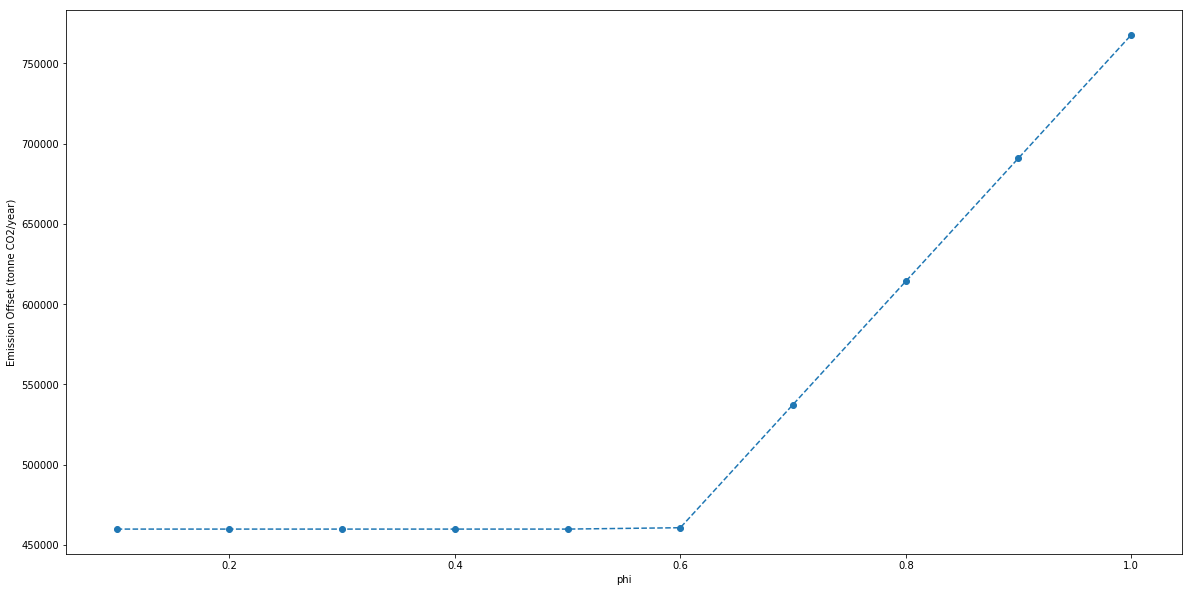

In [80]:
em_offset_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    em_offset = df.loc[df['variable']=='em_offset','value'].tolist()[0]
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    em_offset_list.append(em_offset)
    phi_list.append(phi)

print(em_offset_list)
print(phi_list)
create_plot_list(phi_list,em_offset_list,'phi','Emission Offset (tonne CO2/year)')

In [81]:
temp_dict = {'phi': phi_list,'emission offset (tonne CO2/year)': em_offset_list}
emission_offset_df = pd.DataFrame(temp_dict)
emission_offset_df.set_index('phi',inplace=True)
max_emission_offset = max(em_offset_list)
emission_offset_df['% of max emission offset'] = round(emission_offset_df['emission offset (tonne CO2/year)'] / max_emission_offset*100,1)
display(emission_offset_df)

,emission offset (tonne CO2/year),% of max emission offset
phi,,
0.1,459822.3400,59.9
0.2,459822.3400,59.9
0.3,459822.3400,59.9
0.4,459822.3400,59.9
0.5,459822.3400,59.9
0.6,460675.4900,60.0
0.7,537454.7400,70.0
0.8,614233.9800,80.0
0.9,691013.2300,90.0


### Total Cost 

[44.499298, 44.499298, 44.499298, 44.499298, 44.499298, 44.499356, 44.511164, 44.531683, 44.562057, 342.478]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


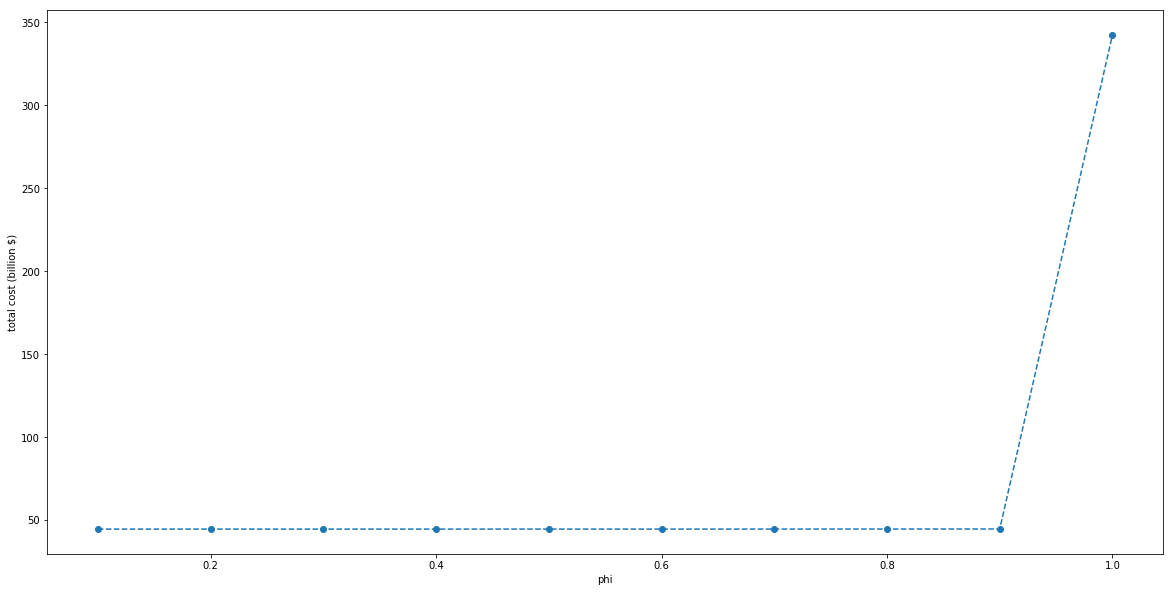

In [82]:
total_cost_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    total_cost = df.loc[df['variable']=='total_cost','value'].tolist()[0]
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    total_cost_list.append(total_cost/10**9)
    phi_list.append(phi)

print(total_cost_list)
print(phi_list)
create_plot_list(phi_list,total_cost_list,'phi','total cost (billion $)')

In [83]:
temp_dict = {'phi': phi_list,'total cost (billion $)': total_cost_list}
total_cost_df = pd.DataFrame(temp_dict)
total_cost_df.set_index('phi',inplace=True)
display(total_cost_df)

,total cost (billion $)
phi,
0.1,44.499298
0.2,44.499298
0.3,44.499298
0.4,44.499298
0.5,44.499298
0.6,44.499356
0.7,44.511164
0.8,44.531683
0.9,44.562057


### Total Cost to Emission Offset

In [84]:
cost_to_offset = pd.merge(emission_offset_df[['emission offset (tonne CO2/year)']],total_cost_df[['total cost (billion $)']], how='inner',left_index=True, right_index=True)
display(cost_to_offset)
cost_to_offset['cost/offset [$/(tonne CO2/year)]'] = cost_to_offset['total cost (billion $)'] * (10**9) / cost_to_offset['emission offset (tonne CO2/year)']
display(cost_to_offset)
cost_to_offset.to_clipboard(excel=True)

,emission offset (tonne CO2/year),total cost (billion $)
phi,,
0.1,459822.3400,44.499298
0.2,459822.3400,44.499298
0.3,459822.3400,44.499298
0.4,459822.3400,44.499298
0.5,459822.3400,44.499298
0.6,460675.4900,44.499356
0.7,537454.7400,44.511164
0.8,614233.9800,44.531683
0.9,691013.2300,44.562057


,emission offset (tonne CO2/year),total cost (billion $),cost/offset [$/(tonne CO2/year)]
phi,,,
0.1,459822.3400,44.499298,96774.980528
0.2,459822.3400,44.499298,96774.980528
0.3,459822.3400,44.499298,96774.980528
0.4,459822.3400,44.499298,96774.980528
0.5,459822.3400,44.499298,96774.980528
0.6,460675.4900,44.499356,96595.883580
0.7,537454.7400,44.511164,82818.441605
0.8,614233.9800,44.531683,72499.543252
0.9,691013.2300,44.562057,64487.993956


### Number of electrolyzers 

[2611.0, 2611.0, 2611.0, 2611.0, 2611.0, 2611.0, 2611.0, 2640.0, 2640.0, 3510.0]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


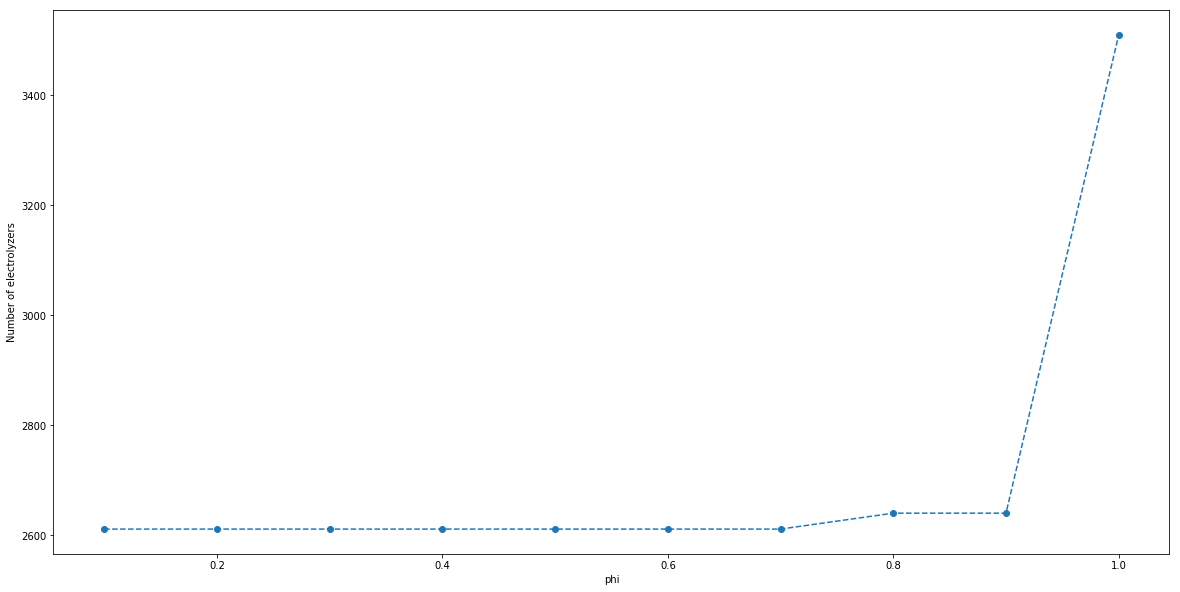

In [85]:
N_electrolyzer_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    N_electrolyzer = df.loc[df['variable']=='N_electrolyzer','value'].tolist()[0]
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    N_electrolyzer_list.append(N_electrolyzer)
    phi_list.append(phi)

print(N_electrolyzer_list)
print(phi_list)
create_plot_list(phi_list,N_electrolyzer_list,'phi','Number of electrolyzers')

In [86]:
temp_dict = {'phi': phi_list,'Number of electrolyzer': N_electrolyzer_list}
N_electrolyzer_df = pd.DataFrame(temp_dict)
N_electrolyzer_df.set_index('phi',inplace=True)
display(N_electrolyzer_df)
N_electrolyzer_df.to_clipboard(excel=True)

,Number of electrolyzer
phi,
0.1,2611.0
0.2,2611.0
0.3,2611.0
0.4,2611.0
0.5,2611.0
0.6,2611.0
0.7,2611.0
0.8,2640.0
0.9,2640.0


### Number of Pre-storage Compressors

[1400.0, 1400.0, 1400.0, 1400.0, 1400.0, 1400.0, 1400.0, 1400.0, 1400.0, 2993.0]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


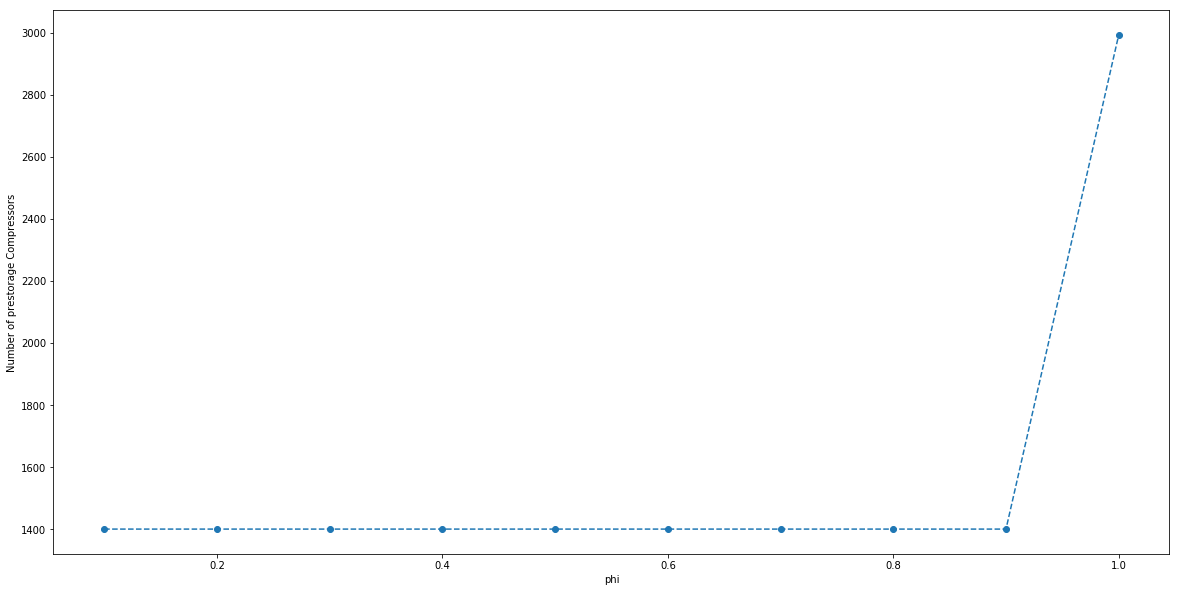

In [87]:
N_prestorage_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    N_prestorage = df.loc[df['variable']=='N_prestorage','value'].tolist()[0]
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    N_prestorage_list.append(N_prestorage)
    phi_list.append(phi)

print(N_prestorage_list)
print(phi_list)
create_plot_list(phi_list,N_prestorage_list,'phi','Number of prestorage Compressors')

### Number of Booster Compressors 

[514.0, 514.0, 514.0, 514.0, 514.0, 514.0, 514.0, 514.0, 514.0, 514.0]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


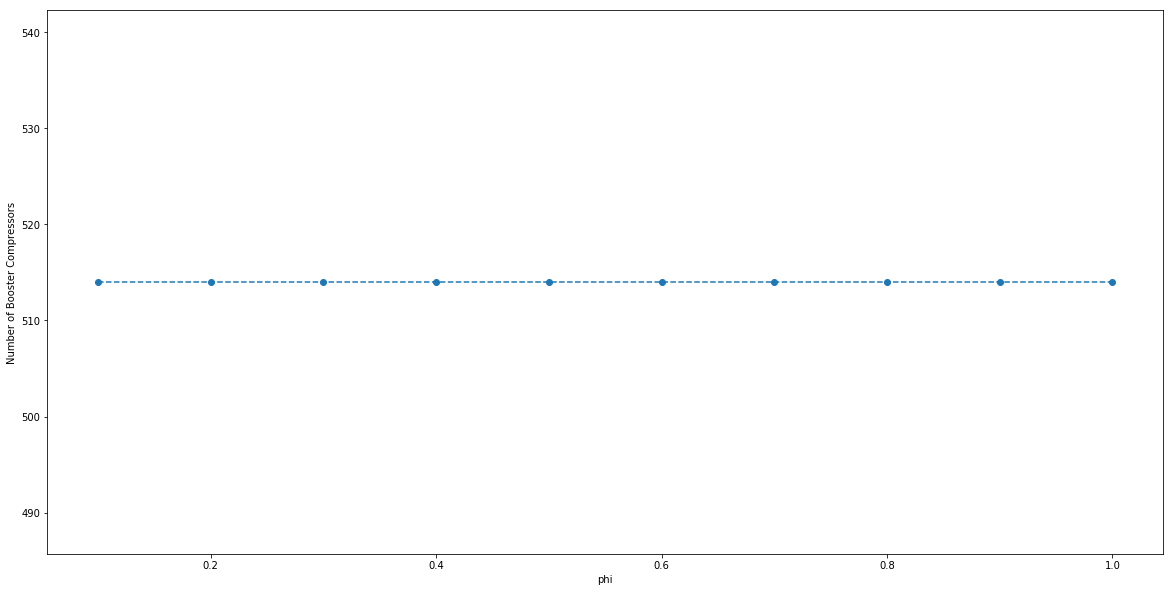

In [88]:
N_booster_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    N_booster = df.loc[df['variable']=='N_booster','value'].tolist()[0]
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    N_booster_list.append(N_booster)
    phi_list.append(phi)

print(N_booster_list)
print(phi_list)
create_plot_list(phi_list,N_booster_list,'phi','Number of Booster Compressors')

### Number of tanks

[70303.0, 70303.0, 70303.0, 70303.0, 70303.0, 70303.0, 70303.0, 70303.0, 70303.0, 558204.0]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


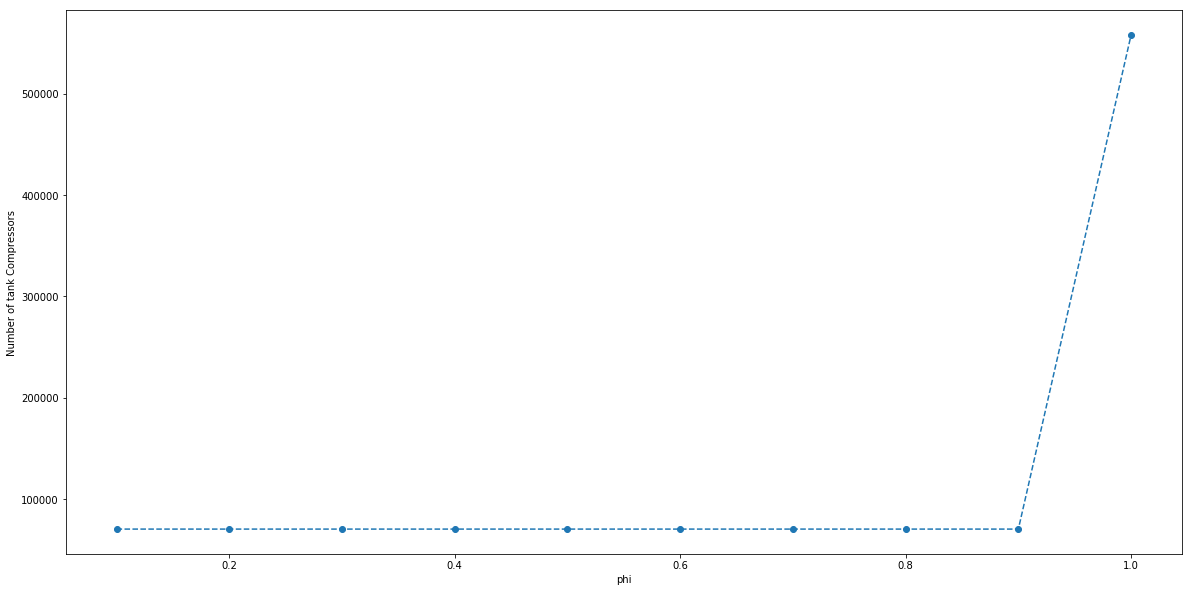

In [89]:
N_tank_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    N_tank = df.loc[df['variable']=='N_tank','value'].tolist()[0]
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    N_tank_list.append(N_tank)
    phi_list.append(phi)

print(N_tank_list)
print(phi_list)
create_plot_list(phi_list,N_tank_list,'phi','Number of tank Compressors')

### Average Tank Inventory 

[21550819.382226035, 21550819.382226035, 21550819.382226035, 21550819.382226035, 21550819.382226035, 21579611.27827627, 21588668.888789967, 21429817.454977177, 21302340.481552515, 156987511.3043379]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


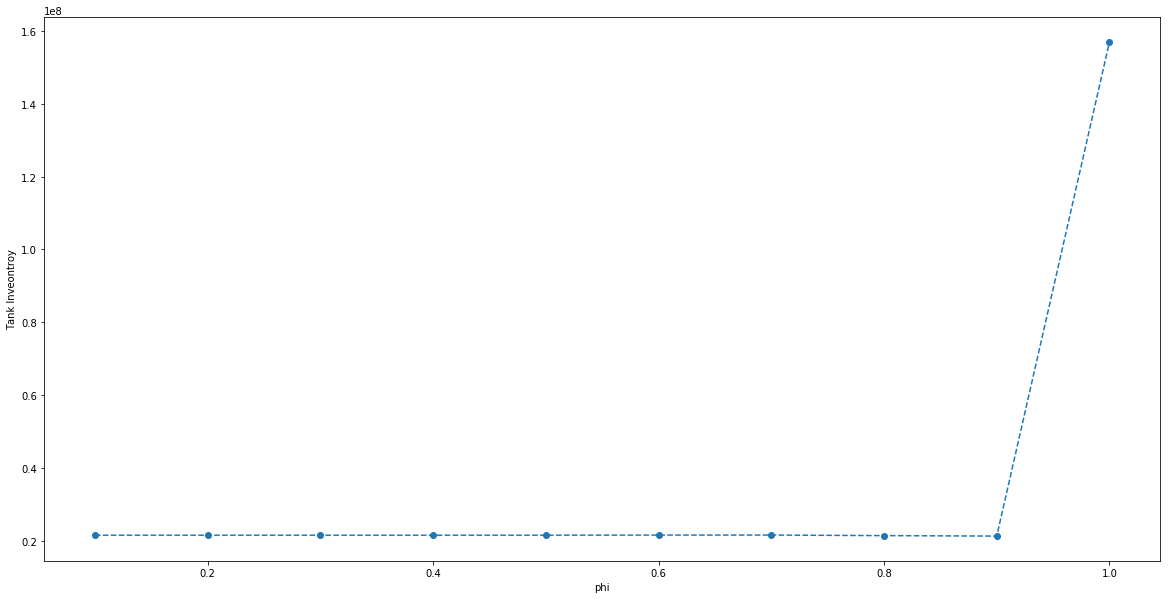

In [90]:
I_tank_list = []
phi_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    I_tank_df = create_var_df_from_result(df,'I_H2_',hour_str='Y')
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    I_tank_mean = I_tank_df['value'].mean()
    I_tank_list.append(I_tank_mean)
    phi_list.append(phi)

print(I_tank_list)
print(phi_list)
create_plot_list(phi_list,I_tank_list,'phi','Tank Inveontroy')


### Tank Inventory Time Series 

Text(0,0.5,'Tank Inventory (m^3 of hydrogen)')

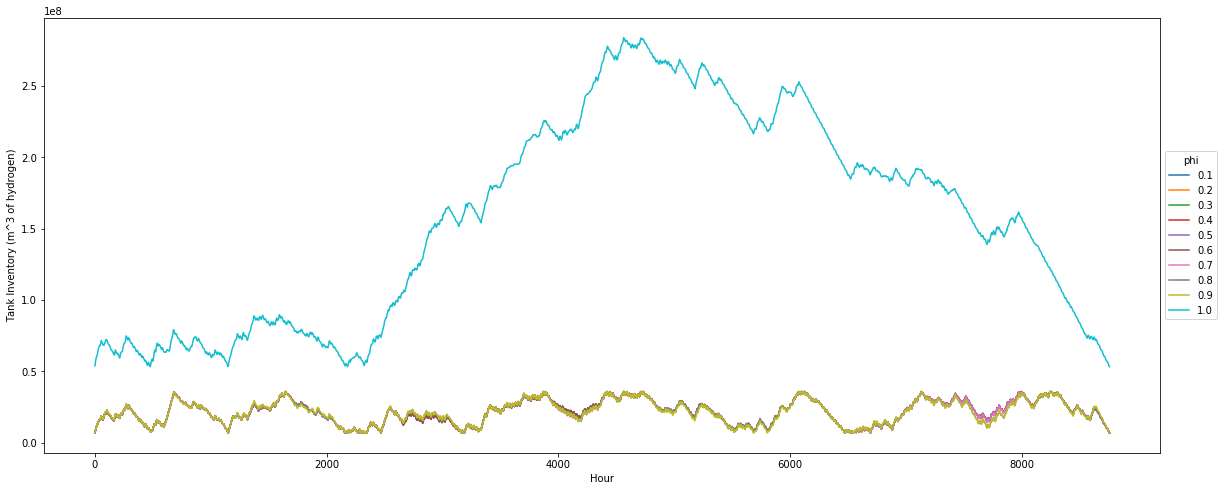

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
    
fig = plt.figure(figsize = [20,8])
ax = fig.add_subplot(111)

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    I_tank_df = create_var_df_from_result(df,'I_H2_',hour_str='Y')
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    plt.plot(I_tank_df['hour'],I_tank_df['value'],label=phi)
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title='phi')
plt.xlabel('Hour')
plt.ylabel('Tank Inventory (m^3 of hydrogen)')


### Electricity Consumption vs. SBG

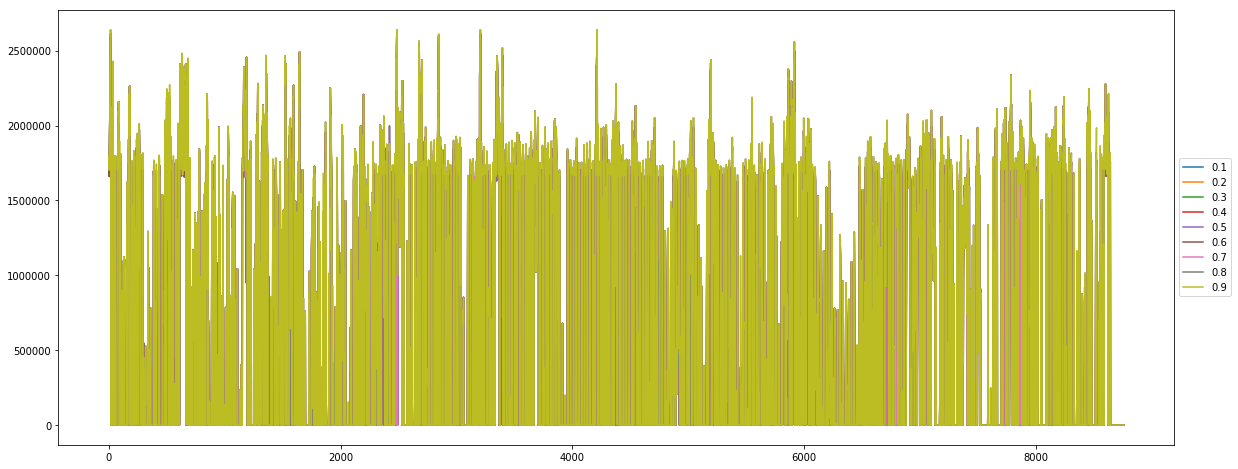

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
    
fig = plt.figure(figsize = [20,8])
ax = fig.add_subplot(111)


for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df]:#,combined_result_phi_10_df]:
    E_df = create_var_df_from_result(df,'E_',hour_str='Y')
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    if phi != 1.0:
        plt.plot(E_df['hour'],E_df['value'],label=phi)
    
# plt.plot(input_df.index.tolist(),input_df['SBG(kWh)'],label='SBG')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Hydrogen Distribution

In [93]:
H2_1_list = []
H2_2_list = []
H2_3_list = []
H2_4_list = []

In [94]:
for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    H2_1_df = create_var_df_from_result(df,'H2_1_',hour_str='Y')
    H2_1_list.append(H2_1_df['value'].sum())
    
    H2_2_df = create_var_df_from_result(df,'H2_2_',hour_str='Y')
    H2_2_list.append(H2_2_df['value'].sum())
    
    H2_3_df = create_var_df_from_result(df,'H2_3_',hour_str='Y')
    H2_3_list.append(H2_3_df['value'].sum())
    
    H2_4_df = create_var_df_from_result(df,'H2_4_',hour_str='Y')
    H2_4_list.append(H2_4_df['value'].sum())
    
    
# H2_summary = pd.DataFrame({'phi' : phi_list,'RNG' : H2_1_list, 'HENG' : H2_2_list, 'Transportation' : H2_3_list, 'Industry' : H2_4_list})
# H2_summary.set_index('phi',inplace=True)
# display(H2_summary)

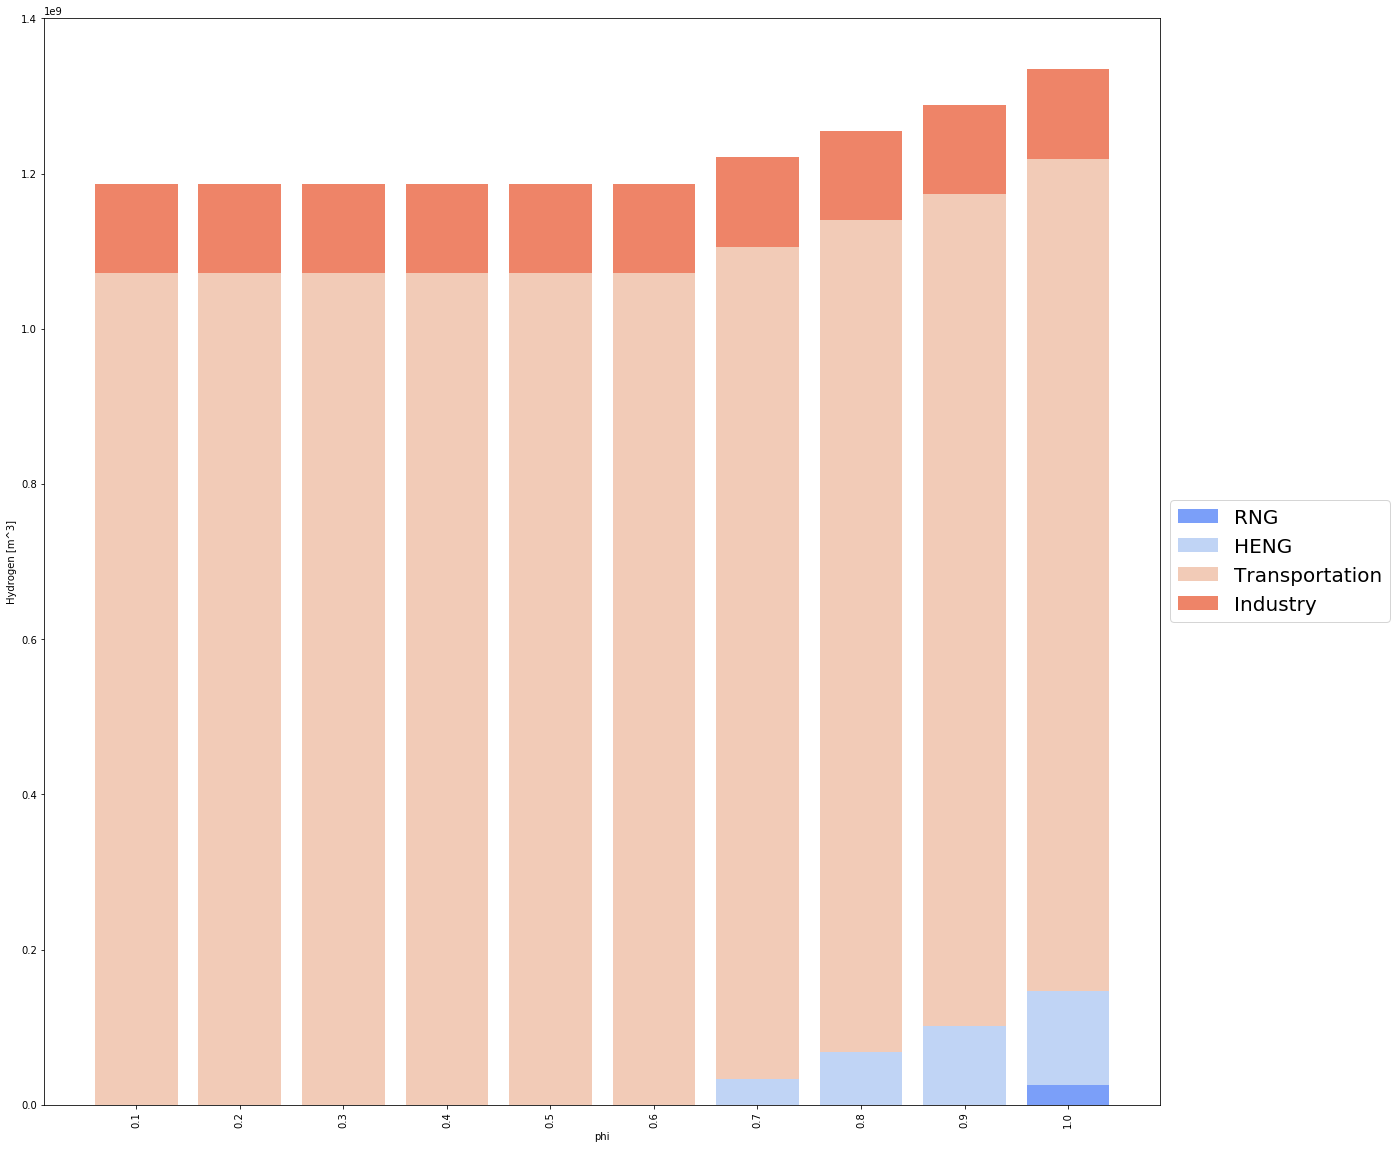

In [95]:
import seaborn as sns 
import numpy as np

color_array = sns.color_palette("coolwarm",4)
label_list = ['RNG','HENG','Transportation','Industry']
ind = [x for x,_ in enumerate(phi_list)]

plt.figure(figsize=(20,20))

plt.bar(ind, H2_1_list, width=0.8, label=label_list[0], color = color_array[0])
plt.bar(ind, H2_2_list, width=0.8, label=label_list[1], color = color_array[1], bottom = H2_1_list)
plt.bar(ind, H2_3_list, width=0.8, label=label_list[2], color = color_array[2], bottom = np.array(H2_1_list) + np.array(H2_2_list))
plt.bar(ind, H2_4_list, width=0.8, label=label_list[3], color = color_array[3], bottom = np.array(H2_1_list) + np.array(H2_2_list) + np.array(H2_3_list))


plt.xticks(ind, phi_list,rotation='vertical')
plt.ylabel('Hydrogen [m^3]')
plt.xlabel("phi")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),prop={'size': 20})
# plt.title(df.index.name)

# plt.savefig(df.index.name +'_multiple_stackedbar.png')

plt.show()
    

In [96]:
H2_summary = pd.DataFrame({'phi' : phi_list,'RNG' : H2_1_list, 'HENG' : H2_2_list, 'Transportation' : H2_3_list, 'Industry' : H2_4_list})
H2_summary.set_index('phi',inplace=True)
display(H2_summary)
H2_summary.div(H2_summary.sum(1)/100,0)

,HENG,Industry,RNG,Transportation
phi,,,,
0.1,4.763240e+04,1.149750e+08,0.000000e+00,1.071887e+09
0.2,4.763240e+04,1.149750e+08,0.000000e+00,1.071887e+09
0.3,4.763240e+04,1.149750e+08,0.000000e+00,1.071887e+09
0.4,4.763240e+04,1.149750e+08,0.000000e+00,1.071887e+09
0.5,4.763240e+04,1.149750e+08,0.000000e+00,1.071887e+09
0.6,3.289336e+05,1.149750e+08,0.000000e+00,1.071887e+09
0.7,3.392629e+07,1.149750e+08,0.000000e+00,1.071887e+09
0.8,6.774017e+07,1.149750e+08,0.000000e+00,1.071887e+09
0.9,1.018206e+08,1.149750e+08,0.000000e+00,1.071887e+09


,HENG,Industry,RNG,Transportation
phi,,,,
0.1,0.004013,9.686921,0.000000,90.309066
0.2,0.004013,9.686921,0.000000,90.309066
0.3,0.004013,9.686921,0.000000,90.309066
0.4,0.004013,9.686921,0.000000,90.309066
0.5,0.004013,9.686921,0.000000,90.309066
0.6,0.027707,9.684626,0.000000,90.287667
0.7,2.779048,9.418095,0.000000,87.802857
0.8,5.399334,9.164260,0.000000,85.436406
0.9,7.901138,8.921902,0.000000,83.176960


### Hydrogen Time Series Graph 

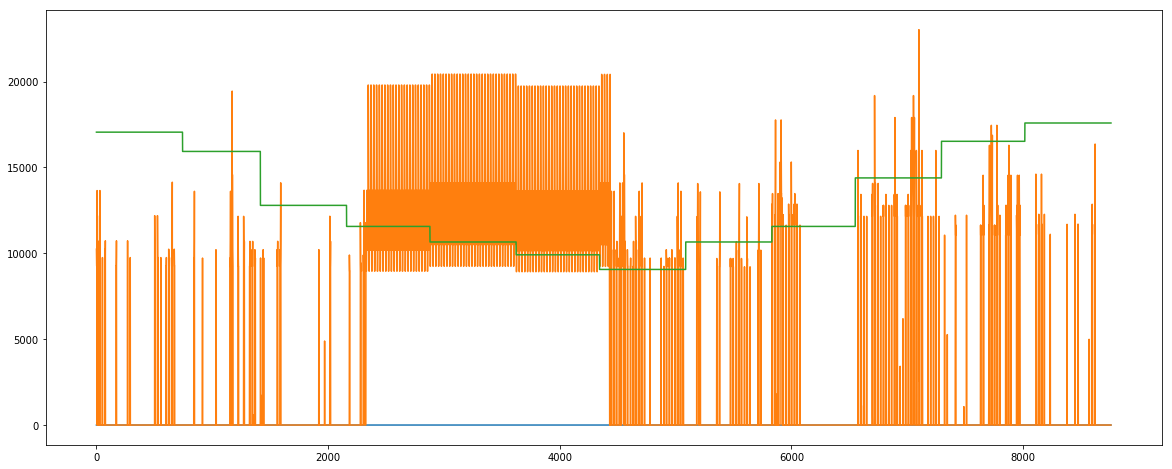

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
    
fig = plt.figure(figsize = [20,8])
ax = fig.add_subplot(111)


for df in [combined_result_phi_7_df]:
    H2_1_df = create_var_df_from_result(df,'H2_1_',hour_str='Y')

    H2_2_df = create_var_df_from_result(df,'H2_2_',hour_str='Y')

    H2_3_df = create_var_df_from_result(df,'H2_3_',hour_str='Y')

    H2_4_df = create_var_df_from_result(df,'H2_4_',hour_str='Y')
   
    plt.plot(H2_1_df['hour'],H2_1_df['value'],label=str(1))
    plt.plot(H2_2_df['hour'],H2_2_df['value'],label=str(2))
#     plt.plot(H2_3_df['hour'],H2_3_df['value'],label=str(3))
    plt.plot(H2_4_df['hour'],H2_4_df['value'],label=str(4))
    

## Results Aggregation 

For economic analysis

In [98]:
em_offset_list = []
total_cost_list = []
capex_list = []
opex_list = []
phi_list = []

#H2 supplied
H2_1_list = []
H2_2_list = []
H2_3_list = []
H2_4_list = []
H2_total_sup = []

#H2 generated 
H2_total_gen = []

I_H2_list = []

for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:
    em_offset = df.loc[df['variable']=='em_offset','value'].tolist()[0]
    em_offset_list.append(em_offset)
     
    total_cost = df.loc[df['variable']=='total_cost','value'].tolist()[0]
    total_cost_list.append(total_cost)
    
    #capex 
    capex_Electrolyzer = df.loc[df['variable']=='CAPEX_Electrolyzer','value'].tolist()[0]
    capex_reactor = df.loc[df['variable']=='CAPEX_reactor','value'].tolist()[0]
    capex_booster = df.loc[df['variable']=='CAPEX_booster_comp','value'].tolist()[0]
    capex_storage = df.loc[df['variable']=='CAPEX_storage','value'].tolist()[0]
    total_capex = capex_Electrolyzer + capex_reactor + capex_booster + capex_storage
    capex_list.append(total_capex)
    
    #opex
    # OPEX is before multiplied to TVM
    opex_reactor = df.loc[df['variable']=='OPEX_reactor','value'].tolist()[0]
    opex_booster = df.loc[df['variable']=='OPEX_booster_comp','value'].tolist()[0]
    opex_sbg = df.loc[df['variable']=='OPEX_SBG','value'].tolist()[0]
    total_opex = opex_reactor + opex_booster + opex_sbg
    opex_list.append(total_opex)
    
    H2_1_df = create_var_df_from_result(df,'H2_1_',hour_str='Y')
    H2_1_list.append(H2_1_df['value'].sum())
    
    H2_2_df = create_var_df_from_result(df,'H2_2_',hour_str='Y')
    H2_2_list.append(H2_2_df['value'].sum())
    
    H2_3_df = create_var_df_from_result(df,'H2_3_',hour_str='Y')
    H2_3_list.append(H2_3_df['value'].sum())
    
    H2_4_df = create_var_df_from_result(df,'H2_4_',hour_str='Y')
    H2_4_list.append(H2_4_df['value'].sum())
    
    
    H2_total_sup = [sum(x) for x in zip(H2_1_list, H2_2_list,H2_3_list,H2_4_list)]
    
    
    H2_direct_df = create_var_df_from_result(df,'H2_direct_',hour_str='Y')
    H2_tank_in_df = create_var_df_from_result(df,'H2_tank_in_',hour_str='Y')
    H2_total_gen.append(H2_direct_df['value'].sum()+H2_tank_in_df['value'].sum())
    

    
    I_H2_df = create_var_df_from_result(df,'I_H2_',hour_str='Y')
    last_I_H2 = list(I_H2_df['value'])[-1]
    N_tank = df.loc[df['variable']=='N_tank','value'].tolist()[0]
    
    phi = df.loc[df['variable']=='phi','value'].tolist()[0]
    phi_list.append(phi)
    
temp_dict = {'phi': phi_list,'emission_offset(tonne CO2/year)': em_offset_list,'total_cost($)': total_cost_list,
             'CAPEX' : capex_list, 'OPEX' : opex_list,
             'RNG_H2(m^3)':H2_1_list, 'HENG_H2(m^3)': H2_2_list, 'Transportation_H2(m^3)': H2_3_list, 'Industry_H2(m^3)': H2_4_list,
             'H2_supplied(m^3)':H2_total_sup, 'H2_generated(m^3)':H2_total_gen, 'last_inventory(m^3)':last_I_H2,
            'N_tank*Imin(m^3)':N_tank*I_min} 
temp_df = pd.DataFrame(temp_dict)




# for df in [combined_result_phi_1_df,combined_result_phi_2_df,combined_result_phi_3_df,combined_result_phi_4_df,combined_result_phi_5_df,combined_result_phi_6_df,combined_result_phi_7_df,combined_result_phi_8_df,combined_result_phi_9_df,combined_result_phi_10_df]:

    



In [99]:
temp_df

,CAPEX,H2_generated(m^3),H2_supplied(m^3),HENG_H2(m^3),Industry_H2(m^3),N_tank*Imin(m^3),OPEX,RNG_H2(m^3),Transportation_H2(m^3),emission_offset(tonne CO2/year),last_inventory(m^3),phi,total_cost($)
0,4.387146e+10,1.186910e+09,1.186910e+09,4.763240e+04,1.149750e+08,5.330055e+07,63947864.9,0.000000e+00,1.071887e+09,459822.3400,53300548.0,0.1,4.449930e+10
1,4.387146e+10,1.186910e+09,1.186910e+09,4.763240e+04,1.149750e+08,5.330055e+07,63947864.9,0.000000e+00,1.071887e+09,459822.3400,53300548.0,0.2,4.449930e+10
2,4.387146e+10,1.186910e+09,1.186910e+09,4.763240e+04,1.149750e+08,5.330055e+07,63947864.9,0.000000e+00,1.071887e+09,459822.3400,53300548.0,0.3,4.449930e+10
3,4.387146e+10,1.186910e+09,1.186910e+09,4.763240e+04,1.149750e+08,5.330055e+07,63947864.9,0.000000e+00,1.071887e+09,459822.3400,53300548.0,0.4,4.449930e+10
4,4.387146e+10,1.186910e+09,1.186910e+09,4.763240e+04,1.149750e+08,5.330055e+07,63947864.9,0.000000e+00,1.071887e+09,459822.3400,53300548.0,0.5,4.449930e+10
5,4.387146e+10,1.187191e+09,1.187191e+09,3.289336e+05,1.149750e+08,5.330055e+07,63953745.9,0.000000e+00,1.071887e+09,460675.4900,53300548.0,0.6,4.449936e+10
6,4.387146e+10,1.220788e+09,1.220788e+09,3.392629e+07,1.149750e+08,5.330055e+07,65156479.9,0.000000e+00,1.071887e+09,537454.7400,53300548.0,0.7,4.451116e+10
7,4.387146e+10,1.254602e+09,1.254602e+09,6.774017e+07,1.149750e+08,5.330055e+07,67246064.9,0.000000e+00,1.071887e+09,614233.9800,53300548.0,0.8,4.453168e+10
8,4.387146e+10,1.288683e+09,1.288683e+09,1.018206e+08,1.149750e+08,5.330055e+07,70339705.9,0.000000e+00,1.071887e+09,691013.2300,53300548.0,0.9,4.456206e+10
9,3.415400e+11,1.334090e+09,1.334090e+09,1.211119e+08,1.149750e+08,5.330055e+07,95539252.5,2.611633e+07,1.071887e+09,767792.4754,53300548.0,1.0,3.424780e+11


The last hour inventory is approximately equal to the number of tanks * I_min  for industry and transportation sectors

In [100]:
temp_df.to_csv('combined_pathway_result.csv')